# EMNIST DATASET

load network
check IF
compare btw TF code
check retrain & IF
sorting & relabeling

## IHVP

Algorithms for Inverse of Hessian Vector Product (CG & SE)

In [1]:
import cntk as C
from cntk.device import try_set_default_device, gpu
try_set_default_device(gpu(0))

import numpy as np
import time

from torch.utils.data import DataLoader

In [2]:
# Hessian Vector Product

def grad_inner_product(grad1, grad2):
    # inner product for dictionary-format gradients (output scalar value)
    
    val = 0
    
    for ks in grad1.keys():
        val += np.sum(np.multiply(grad1[ks],grad2[ks]))
        
    return val

def weight_update(w, v, r):
    # w: weights of neural network (tuple)
    # v: value for delta w (dictionary, e.g., gradient value)
    # r: hyperparameter for a gradient (scalar)

    for p in w:
        p.value += r * v[p]

def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-2
    
    assert type(x)==dict, "Input of HVP is wrong. this should be dictionary"
     
    w = y.parameters
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=params)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=params)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp


In [38]:
def HVP_minibatch_val(model, y, v, dataloader):
    # Calculate Hessian vector product w.r.t whole dataset
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (numeric dictionary, e.g. v_test)
    # dataloader: training set dataloader
    
    # hyperparameters
    damping = 0.0 # convexity term; paper ref:0.01
    
    hvp_batch = {ks: [] for ks in v.keys()}
    
    for img, lb in dataloader:
        img = img.numpy(); lb = lb.numpy()
        x_feed = {model.X: img, model.y:lb}
        hvp = HVP(y,x_feed,v)
        # add hvp value
        [hvp_batch[ks].append(hvp[ks]/img.shape[0]) for ks in hvp.keys()]
        
    hvp_mean = {ks: np.mean(hvp_batch[ks], axis=0) + damping*v[ks] for ks in hvp_batch.keys()}
    
    return hvp_mean

# x: solution vector for conjugate gradient, whose shape is same as flattened gradient. NOT feed dict value

def dic2vec(dic):
    # convert a dictionary with matrix values to a 1D vector
    # e.g. gradient of network -> 1D vector
    vec = np.concatenate([val.reshape(-1) for val in dic.values()])
    
    return vec

def vec2dic(vec, fmt):
    # convert a 1D vector to a dictionary of format fmt
    # fmt = {key: val.shape for (key,val) in dict}
    fmt_idx = [np.prod(val) for val in fmt.values()]
    #lambda ls, idx: [ls[sum(idx[:i]):sum(idx[:i+1])] for i in range(len(idx))]
    vec_split = [vec[sum(fmt_idx[:i]):sum(fmt_idx[:i+1])] for i in range(len(fmt_idx))]
    dic = {key: vec_split[i].reshape(shape) for (i,(key,shape)) in enumerate(fmt.items())}

    return dic


def get_fmin_loss_fn(model, y, v, dataloader):
    
    def get_fmin_loss(x):
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(model, y, x_dic, dataloader)
        
        return 0.5 * grad_inner_product(hvp_val, x_dic) - grad_inner_product(v, x_dic)
    
    return get_fmin_loss

def get_fmin_grad_fn(model, y, v, dataloader):
    
    def get_fmin_grad(x):
        # x: 1D vector
        x_dic = vec2dic(x, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(model, y, x_dic, dataloader)
        hvp_flat = dic2vec(hvp_val)
        v_flat = dic2vec(v)
        
        return hvp_flat - v_flat
    
    return get_fmin_grad

def get_fmin_hvp_fn(model, y, v, dataloader):

    def get_fmin_hvp(x, p):
        p_dic = vec2dic(p, {key: val.shape for (key, val) in v.items()})
        hvp_val = HVP_minibatch_val(model, y, p_dic, dataloader)
        hvp_flat = dic2vec(hvp_val)

        return hvp_flat
    
    return get_fmin_hvp

def get_inverse_hvp_cg(model, y, v, data_set):
    # return x, which is the solution of QP, whose value is H^-1 v

    # hyperparameters
    batch_size = 50
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    fmin_loss_fn = get_fmin_loss_fn(model, y, v, dataloader)
    fmin_grad_fn = get_fmin_grad_fn(model, y, v, dataloader)
    fmin_hvp_fn = get_fmin_hvp_fn(model, y, v, dataloader)
    
    fmin_results = fmin_ncg(\
            f = fmin_loss_fn, x0 = dic2vec(v), fprime = fmin_grad_fn,\
            fhess_p = fmin_hvp_fn, avextol = 1e-8, maxiter = 1e2)
    
    #return fmin_results
    return vec2dic(fmin_results, {key: val.shape for (key, val) in v.items()})

In [35]:
# stochastic estimation
def get_inverse_hvp_se(model, y, v, data_set, **kwargs):
    # Calculate inverse hessian vector product over the training set
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    # kwargs: hyperparameters for stochastic estimation
    recursion_depth = kwargs.pop('recursion_depth', 5) # epoch
    scale = kwargs.pop('scale', 1e1) # similar to learning rate
    damping = kwargs.pop('damping', 0.0) # paper reference: 0.01
    batch_size = kwargs.pop('batch_size', 1)
    num_samples = kwargs.pop('num_samples', 1) # the number of samples(:stochatic estimation of IF) to be averaged
    verbose = kwargs.pop('verbose', False)
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    inv_hvps = []
    
    params = y.parameters
    
    for i in range(num_samples):
        # obtain num_samples inverse hvps
        cur_estimate = v
        
        for depth in range(recursion_depth):
            # epoch-scale recursion depth
            t1 = time.time()
            for img, lb in dataloader:
                img = img.numpy(); lb = lb.numpy()
                x_feed = {model.X: img, model.y:lb}
                hvp = HVP(y,x_feed,cur_estimate)
                # cur_estimate = v + (1-damping)*cur_estimate + 1/scale*(hvp/batch_size)
                cur_estimate = {ks: v[ks] + (1-damping/scale)*cur_estimate[ks] - (1/scale)*hvp[ks]/batch_size for ks in cur_estimate.keys()}
            if verbose:
                print('#w: \n', list(map(lambda x: x.value, params)), '\n#hvp: \n', hvp, '\n#ihvp: \n', cur_estimate)
                print("Recursion depth: {}, norm: {}, time: {} \n".format(depth, np.sqrt(grad_inner_product(cur_estimate,cur_estimate)),time.time()-t1))
        
        inv_hvp = {ks: (1/scale)*cur_estimate[ks] for ks in cur_estimate.keys()}
        inv_hvps.append(inv_hvp)
    
    inv_hvp_val = {ks: np.mean([inv_hvps[i][ks] for i in range(num_samples)], axis=0) for ks in inv_hvps[0].keys()}
    
    return inv_hvp_val

In [9]:
# toy example for inverse HVP (CG and SE)

class SimpleNet(object):
    def __init__(self):
        self.X = C.input_variable(shape=(1,))
        self.h = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.X)
        self.pred = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.h)
        self.y = C.input_variable(shape=(1,))
        #self.loss = C.reduce_l2(self.pred-self.y)
        self.loss = C.squared_error(self.pred, self.y)
        
class SimpleDataset(object):
    def __init__(self, images, labels):
        self._images, self._labels = images, labels
    
    def __getitem__(self, index):
        X = self._images[index]
        y = self._labels[index]
        
        return X, y
    
    def __len__(self):
        return len(self._images)


net = SimpleNet()

params = net.pred.parameters

x_feed = {net.X:np.array([[2.]],dtype=np.float32), net.y:np.array([[1.]],dtype=np.float32)}
v_feed = {p: np.ones_like(p.value) for p in params}

print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))
params[0].value = np.asarray([[1.]])
params[1].value = np.asarray([[1./3.]])
print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))

print('hvp', HVP(net.loss, x_feed, v_feed))

images = np.asarray([[2.],[2.]], dtype=np.float32)
labels = np.asarray([[1.],[1.]], dtype=np.float32)
#images = np.asarray([[2.]], dtype=np.float32)
#labels = np.asarray([[1.]], dtype=np.float32)

train_set = SimpleDataset(images,labels)

print('inverse hvp', get_inverse_hvp_cg(net, net.loss, v_feed, train_set))
print('inverse hvp', get_inverse_hvp_se(net, net.loss, v_feed, train_set,**{'scale':20, 'damping':0.1}))
print('inverse hvp', get_inverse_hvp_se(net, net.loss, v_feed, train_set,**{'scale':10, 'damping':0.1}))

w1 = 
 [[ 0.0370382]] 
w2 = 
 [[-0.03171763]] 
loss = 
 [ 1.00470448]
w1 = 
 [[ 1.]] 
w2 = 
 [[ 0.33333334]] 
loss = 
 [ 0.1111111]
hvp {Parameter('W', [], [1 x 1]): array([[ 2.22302079]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 9.33413506]], dtype=float32)}
         Current function value: -0.583325
         Iterations: 5
         Function evaluations: 26
         Gradient evaluations: 19
         Hessian evaluations: 12
inverse hvp [ 1.24996293 -0.08331362]
inverse hvp {Parameter('W', [], [1 x 1]): array([[ 1.05965364]], dtype=float32), Parameter('W', [], [1 x 1]): array([[-0.04848924]], dtype=float32)}
inverse hvp {Parameter('W', [], [1 x 1]): array([[ 1.08393216]], dtype=float32), Parameter('W', [], [1 x 1]): array([[-0.05433288]], dtype=float32)}


## EMNIST dataset

In [22]:
import os, sys
sys.path.append('../refer/boot_strapping')
import json

from datasets import dataset28 as dataset

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils.data import DataLoader

In [23]:
def show_image_from_data(img):
    # show image from dataset
    # img: (C,W,H) numpy array
    img_show = np.squeeze(np.transpose(img, [1,2,0]))
    imshow(img_show)
    plt.show()

In [24]:
# emnist dataset
root_dir = '/Data/emnist/balanced/original'

# sample sized
trainval_list, anno_dict = dataset.read_data_subset(root_dir, mode='train1', sample_size=1000)
test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=1000)

with open('/Data/emnist/balanced/original/annotation/annotation1_wp_0.3.json','r') as fid:
    noisy_anno_dict = json.load(fid)

train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict)
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# emnist dataset: SANITY CHECK
print(len(test_set), type(test_set))
print(len(test_list))

1000 <class 'datasets.dataset28.LazyDataset'>
1000


In [25]:
# emnist network
from models.nn import VGG as ConvNet

hp_d = dict() # hyperparameters for a network
net = ConvNet(train_set.__getitem__(0)[0].shape, len(anno_dict['classes']), **hp_d)
net.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')

# emnist network: SANITY CHECK
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = net.predict(test_set, **hp_d)
total_time = time.time() - start_time

print('Test error rate: {}'.format(test_score))
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))
print('Confusion matrix: \n{}'.format(confusion_matrix))

conv1.shape (64, 28, 28)
pool1.shape (64, 14, 14)
conv2.shape (128, 14, 14)
pool2.shape (128, 7, 7)
conv3.shape (256, 7, 7)
pool3.shape (256, 4, 4)
Test error rate: 0.11570581896551724
Total tack time(sec): 9.851991653442383
Tact time per image(sec): 0.009851991653442383
Confusion matrix: 
[[18  0  0 ...,  0  0  0]
 [ 0 18  0 ...,  0  0  0]
 [ 0  0 15 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 17  0  0]
 [ 0  0  0 ...,  0 18  0]
 [ 0  1  0 ...,  0  0 18]]


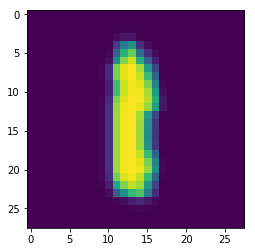

ground truth label:  L
network prediction:  I


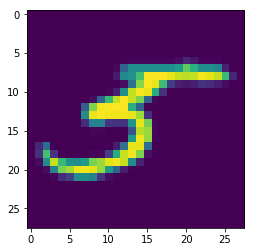

25.3030843472
3505.32309139


In [26]:
# hessian vector product w.r.t. test image

params = net.logits.parameters

img_test, lb_test = test_set.__getitem__(1)
show_image_from_data(img_test)

print('ground truth label: ', anno_dict['classes'][str(np.argmax(lb_test))])
print('network prediction: ', anno_dict['classes'][str(np.argmax(net.logits.eval({net.X:img_test})))])

v_test = net.loss.grad({net.X:img_test, net.y:lb_test}, wrt=params)

# HVP(y,x,v)
img, lb = train_set.__getitem__(1)
img.shape
show_image_from_data(img)

v_train = net.loss.grad({net.X:img, net.y:lb}, wrt=params)

hvp = HVP(net.loss, {net.X:img, net.y:lb}, v_test)

print(grad_inner_product(hvp, v_test))
print(grad_inner_product(v_train, v_test))

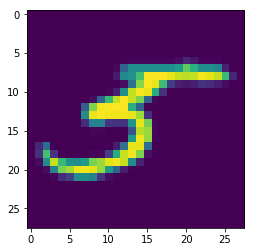

(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]), Parameter('W', [], [256 x 4 x 4 x 2048]), Parameter('b', [], [2048]), Parameter('W', [], [256 x 128 x 3 x 3]), Parameter('b', [], [256 x 1 x 1]), Parameter('W', [], [128 x 64 x 3 x 3]), Parameter('b', [], [128 x 1 x 1]), Parameter('W', [], [64 x 1 x 3 x 3]), Parameter('b', [], [64 x 1 x 1]))
(Parameter('W', [], [2048 x 47]), Parameter('b', [], [47]), Parameter('W', [], [256 x 4 x 4 x 2048]), Parameter('b', [], [2048]), Parameter('W', [], [256 x 128 x 3 x 3]), Parameter('b', [], [256 x 1 x 1]), Parameter('W', [], [128 x 64 x 3 x 3]), Parameter('b', [], [128 x 1 x 1]), Parameter('W', [], [64 x 1 x 3 x 3]), Parameter('b', [], [64 x 1 x 1]))


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in subtract


In [ ]:
img, lb = train_set.__getitem__(1)
show_image_from_data(img)

v_train = net.loss.grad({net.X:img, net.y:lb}, wrt=params)

net.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')
net.loss.eval({net.X: img, net.y:lb})

print(net.loss.parameters)
print(net.logits.parameters)

t1 = time.time()
ihvp_cg = get_inverse_hvp_cg(net, net.loss, v_test, train_set)
IF_cg = grad_inner_product(ihvp_cg, v_train)/1000 # loss difference = -1/num_sample * influence function
print('it takes {} sec, and its value {}'.format(time.time()-t1, IF_cg))

#t1 = time.time()
#ihvp_se = get_inverse_hvp_se(net, net.loss, v_test, train_set,**{'scale':20, 'damping':0.1, 'verbose':True})
#IF_se = grad_inner_product(ihvp_se, v_train)/1000 # loss difference = -1/num_sample * influence function
#print('it takes {} sec'.format(time.time()-t1))

#print(IF_cg, IF_se)

In [ ]:
# sorting with IF

# 1: v_test^T * v_train
# 2: v_cg^T * v_train
# 3: v_se^T * v_train

# visualization w.r.t. top 5 sampling